# Цель работы

Приобретение практических навыков в моделировании однослойных
бинарных нейронных сетей, обучаемых методом коррекции ошибки.

# Задание

Вариант 1: Разработать структуру сети и обучить такую сеть распознавать символы: [Г, Л, В, 0, 1]. Обучение производится с помощью метода коррекции ошибки. Дополнительно требуется подготовить тренировочную (для обучения) и тестовую выборку.

# Набор данных

В процессе выполнения работы было подготовлено множество изображений в количестве 25 штук на каждый символ из задания.
Множество поделено на тренировочную и тестовую выборку в пропорции 4:1. Пример изображений можно видеть ниже.

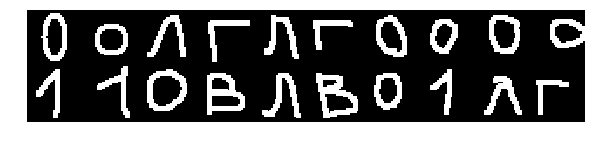

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import dataset

(x_train, y_train), (x_test, y_test) = dataset.load_data()

samples = np.vstack([np.hstack(x_train[:10]), np.hstack(x_train[10:20])])

plt.figure(figsize=(10, 10)); plt.axis('off')
plt.imshow(samples, cmap='gray')

# Обучение

Открываем заранее подготовленные обучающую и тестовую выборки с метками и дополнительно преобразуем данные в необходимый формат.

In [2]:
import dataset
from nnbinary import to_categorical

(x_train, y_train), (x_test, y_test) = dataset.load_data()
input_shape = x_train.shape[1:]
number_of_classes = 5

white_color_threshold = 10
X_train = (x_train > white_color_threshold).astype('float32')
X_test = (x_test > white_color_threshold).astype('float32')

Y_train = to_categorical(y_train, list(range(number_of_classes)))
Y_test = to_categorical(y_test, list(range(number_of_classes)))

Попробуем обучить сеть. Реализацию класса OneLayerBinaryNN можно найти у меня на [GitHub](https://github.com/MrP4p3r).

In [3]:
from nnbinary import OneLayerBinaryNN

max_epochs = 100

net = OneLayerBinaryNN(input_shape, number_of_classes)
net.fit(X_train, Y_train, max_epochs, X_test, Y_test, verbose=1)

Epoch 0.  train acc: 0.7500  test acc: 0.5600
Epoch 1.  train acc: 0.9000  test acc: 0.6000
Epoch 2.  train acc: 0.9200  test acc: 0.7600
Epoch 3.  train acc: 0.9700  test acc: 0.6400
Epoch 4.  train acc: 0.9900  test acc: 0.6000
Epoch 5.  train acc: 0.9900  test acc: 0.6400
Epoch 6.  train acc: 1.0000  test acc: 0.6000
Early stopping. Train accuracy is 100%
Done


Как видно выше, точность на тестовой выборке оставляет желать лучшего.
Посмотрим, как выглядят веса, соответствующие меткам.

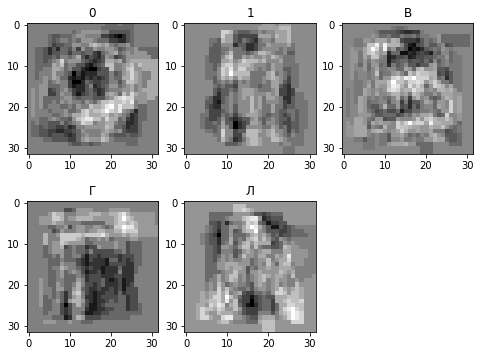

In [4]:
plt.figure(figsize=(8, 6))
label_names = ['0', '1', 'В', 'Г', 'Л']
for idx in range(net.weights.shape[0]):
    plt.subplot(231 + idx)
    plt.imshow(net.weights[idx], cmap='gray')
    plt.title(label_names[idx])

Выходной вектор сети может содержать несколько единиц. Сеть считает, что изображение принадлежит нескольким классам,
что в контексте этой задачи является неверным. Для улучшения результата можно воспользоваться чем-то вроде бинарного
варианта softmax активации. Такая функция работает по принципу "победитель забирает все". То есть, выходной вектор
содержит только одну единицу, соответствующую максимальной сумме произведений входов на веса.

In [5]:
def binary_softmax(raw_outputs):
    maxidx = np.argmax(raw_outputs)
    outputs = np.zeros(raw_outputs.shape[0])
    outputs[maxidx] = 1.
    return outputs

max_epochs = 100

net2 = OneLayerBinaryNN(input_shape, number_of_classes, activation=binary_softmax)
net2.fit(X_train, Y_train, max_epochs, X_test, Y_test, verbose=1)

Epoch 0.  train acc: 0.6500  test acc: 0.4800
Epoch 1.  train acc: 0.9500  test acc: 0.8400
Epoch 2.  train acc: 0.9500  test acc: 0.8800
Epoch 3.  train acc: 1.0000  test acc: 0.8800
Early stopping. Train accuracy is 100%
Done


Можно заметить, что обобщенные образы на изображения весов сети выделяются сильнее. Причиной этому является корректировка весов в большую сторону даже в том случае, когда пороговая функция вернула единицу. То есть, для некорректно сработавших весов коррекция идет "в минус", а для тех, которые сработали не достатоно сильно, идет коррекция "в плюс".

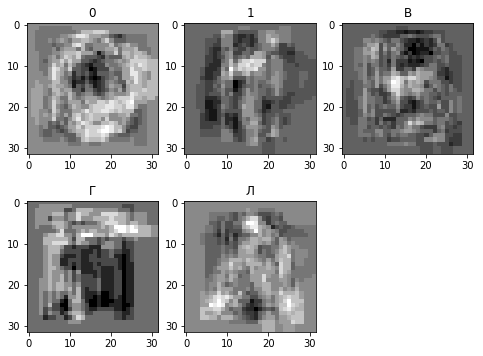

In [6]:
plt.figure(figsize=(8, 6))
label_names = ['0', '1', 'В', 'Г', 'Л']
for idx in range(net.weights.shape[0]):
    plt.subplot(231 + idx)
    plt.imshow(net2.weights[idx], cmap='gray')
    plt.title(label_names[idx])

# Вывод

Данный метод машинного обучения довольно прост. Однако его использование не гарантирует высокой точности распознавания.

При разделении входных данных на тренировочную и тестовую выборки в разных пропорциях бинарный аналог активации softmax статистически показал более высокую точность в сравнении с пороговой активацией. При разделении данных в пропорции по умолчанию точность поднялась с 60% до 88%. Показательно также обучение сети за меньшее число эпох.